Dataset Size: (318438, 18)

Original Stay Column Values:
['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100']

Class Distribution
Class 1 (Long Stay): 294834, (%92.6)
Class 0 (Short Stay):  23604, (%7.4)


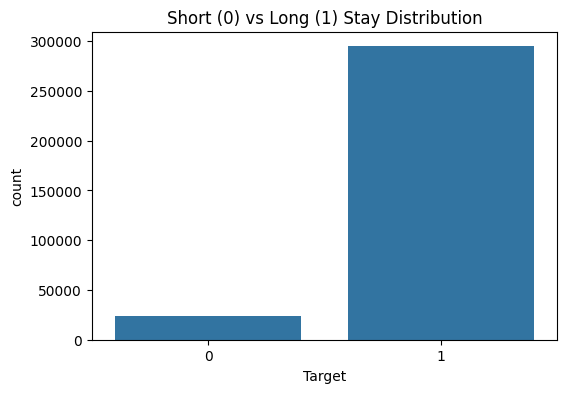

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# project basepath
file_path = 'C:\\Users\\dilad\\OneDrive\\Masaüstü\\icu-stay-prediction\\healthcare\\train_data.csv' 
df = pd.read_csv(file_path)

print("Dataset Size:", df.shape)
print("\nOriginal Stay Column Values:")
print(df['Stay'].unique())

# 0-10 days -> 0 (short stay), others -> 1 (long stay)
def classify_stay(stay_duration):
    if stay_duration == '0-10':
        return 0
    else:
        return 1

# new column
df['Target'] = df['Stay'].apply(classify_stay)

# distribution
print("\nClass Distribution")
counts = df['Target'].value_counts()
percentages = df['Target'].value_counts(normalize=True) * 100

print(f"Class 1 (Long Stay): {counts[1]}, (%{percentages[1]:.1f})")
print(f"Class 0 (Short Stay):  {counts[0]}, (%{percentages[0]:.1f})")

# visualize
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=df)
plt.title('Short (0) vs Long (1) Stay Distribution')
plt.show()

C:\Users\dilad\AppData\Local\Temp\ipykernel_21564\3310570477.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Bed Grade'].fillna(df['Bed Grade'].mode()[0], inplace=True)
C:\Users\dilad\AppData\Local\Temp\ipykernel_21564\3310570477.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as


Training Model...

--- MODEL ---
Accuracy: 0.717750476593942

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73      4740
           1       0.73      0.68      0.71      4702

    accuracy                           0.72      9442
   macro avg       0.72      0.72      0.72      9442
weighted avg       0.72      0.72      0.72      9442



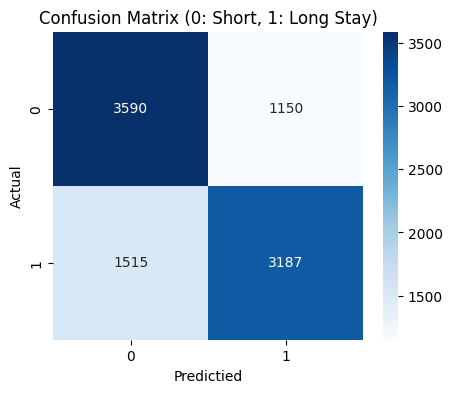

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing - berzat
df['Bed Grade'].fillna(df['Bed Grade'].mode()[0], inplace=True)
df['City_Code_Patient'].fillna(df['City_Code_Patient'].mode()[0], inplace=True)

cols_to_drop = ['case_id', 'patientid', 'Stay']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

le = LabelEncoder()
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])


df_majority = df_clean[df_clean.Target == 1] 
df_minority = df_clean[df_clean.Target == 0] 


df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=len(df_minority), 
                                 random_state=42) 

df_balanced = pd.concat([df_majority_downsampled, df_minority])

# training - yaren
X = df_balanced.drop('Target', axis=1)
y = df_balanced['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining Model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# evaluation - dila
y_pred = model.predict(X_test)

print("\n--- MODEL ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (0: Short, 1: Long Stay)')
plt.ylabel('Actual')
plt.xlabel('Predictied')
plt.show()

In [6]:
import numpy as np

# final prediction system
def predict_final_system():
    print("\n" + "="*60)
    print("CLINICAL PREDICTION SYSTEM (Final Version)")
    print("="*60)

    try:
        # vitals & triage
        print("\n--- VITALS & TRIAGE ---")
        bp = int(input("Systolic Blood Pressure (e.g., 120): "))
        pulse = int(input("Heart Rate (e.g., 80): "))
        
        severity_val = 1 
        severity_desc = "Minor"
        # evaluate vitals
        if bp > 160 or pulse > 110:
            severity_val = 0 
            severity_desc = "Extreme (Critical)"
            print("ALERT: Critical Vitals! Severity set to 'Extreme'.")
        elif bp > 140 or pulse > 100:
            severity_val = 2 
            severity_desc = "Moderate"
            print("NOTE: Elevated Vitals. Severity set to 'Moderate'.")
        else:
            print("NOTE: Vitals Stable. Severity set to 'Minor'.")

        
        print("\n--- ADMISSION TYPE ---")
        print("1: Emergency")
        print("2: Trauma")
        print("3: Urgent")
        adm_choice = int(input("Select Type (1-3): "))
        adm_map = {1: 0, 2: 1, 3: 2}
        selected_adm = adm_map.get(adm_choice, 2)

        
        print("\n--- DEPARTMENT ---")
        dept_names = ['Anesthesia', 'Gynecology', 'Radiotherapy', 'Surgery', 'TB & Chest disease']
        for i, name in enumerate(dept_names, 1):
            print(f"{i}: {name}")
        dept_choice = int(input("Select Department (1-5): "))
        selected_dept = dept_choice - 1 

        
        print("\n--- PATIENT HISTORY ---")
        
        
        print("-" * 45)
        print("AGE REFERENCE TABLE:")
        print("0: 0-10   | 1: 11-20  | 2: 21-30  | 3: 31-40")
        print("4: 41-50  | 5: 51-60  | 6: 61-70  | 7: 71-80")
        print("8: 81-90  | 9: 90-100")
        print("-" * 45)
        
        age = int(input("Enter Age Code (0-9): "))
        deposit = float(input("Admission Deposit (e.g., 4000): "))
        visitors = int(input("Visitors with Patient (e.g., 2): "))

       # prepare input for prediction
        new_patient = X_train.mean().values.reshape(1, -1)
        cols = list(X.columns)
        
        
        new_patient[0, cols.index('Admission_Deposit')] = deposit
        new_patient[0, cols.index('Visitors with Patient')] = visitors
        new_patient[0, cols.index('Age')] = age
        
        if 'Type of Admission' in cols:
            new_patient[0, cols.index('Type of Admission')] = selected_adm
        if 'Department' in cols:
            new_patient[0, cols.index('Department')] = selected_dept
        if 'Severity of Illness' in cols:
            new_patient[0, cols.index('Severity of Illness')] = severity_val

        prediction = model.predict(new_patient)[0]
        probs = model.predict_proba(new_patient)[0]

        print("\n" + "*"*45)
        print("FINAL PREDICTION RESULT")
        print("*"*45)
        print(f"Context: {dept_names[selected_dept]} | Age Code: {age} | Severity: {severity_desc}")
        
        if prediction == 0:
            conf = probs[0] * 100
            print(f"\nPREDICTION: SHORT STAY (0-10 Days)")
            print(f"Confidence: {conf:.1f}%")
        else:
            conf = probs[1] * 100
            print(f"\nPREDICTION: LONG STAY (>10 Days)")
            print(f"Confidence: {conf:.1f}%")
            
            if age >= 7: 
                print("Reason: Advanced age significantly increases stay duration.")
            if severity_val == 0:
                print("Reason: Critical vitals require intensive care.")
            if dept_choice == 4:
                print("Reason: Surgery implies recovery period.")

    except Exception as e:
        print("Error:", e)

predict_final_system()


CLINICAL PREDICTION SYSTEM (Final Version)

--- VITALS & TRIAGE ---
NOTE: Vitals Stable. Severity set to 'Minor'.

--- ADMISSION TYPE ---
1: Emergency
2: Trauma
3: Urgent

--- DEPARTMENT ---
1: Anesthesia
2: Gynecology
3: Radiotherapy
4: Surgery
5: TB & Chest disease

--- PATIENT HISTORY ---
---------------------------------------------
AGE REFERENCE TABLE:
0: 0-10   | 1: 11-20  | 2: 21-30  | 3: 31-40
4: 41-50  | 5: 51-60  | 6: 61-70  | 7: 71-80
8: 81-90  | 9: 90-100
---------------------------------------------

*********************************************
FINAL PREDICTION RESULT
*********************************************
Context: Surgery | Age Code: 9 | Severity: Minor

PREDICTION: SHORT STAY (0-10 Days)
Confidence: 60.0%


c:\Users\dilad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\dilad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
import joblib
import os


save_path = 'models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

joblib.dump(model, os.path.join(save_path, 'hospital_model.pkl'))
joblib.dump(list(X.columns), os.path.join(save_path, 'model_columns.pkl'))

print("\nModel and columns saved successfully.")


Model and columns saved successfully.
